# load dependencies, set configurations

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext jupyternotify
%autonotify -a 30

import math
import time
import sys
import os
import random
import pickle

import numpy as np

import keras
import keras.layers
import keras.applications
import keras.backend
import keras.preprocessing.image
import keras.utils
import tensorflow as tf

import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt

import shutil


# configurations

## seeding
os.environ['PYTHONHASHSEED'] = '3'
np.random.seed(3)
random.seed(3)
tf.set_random_seed(3)

## which gpu to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## memory allocation
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)
keras.backend.set_session(session)

## data directory for CUB200 root
PATH_DATA_ROOT_CUB200 = "D:\project\commons\CUB_200_2011"

## network configurations
### number of output classes, 200 for CUB200
NO_CLASS = 200



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# split CUB200 into train, valid 

In [2]:
def split_trainval_CUB200(
    path_root_CUB200
    ,n_sample=0
    
):

    # create directory of all classes for both train and valid
    
    path_data_all = path_root_CUB200+"/images"
    path_data_train = os.path.join(path_root_CUB200, "splitted/train")
    path_data_valid = os.path.join(path_root_CUB200, "splitted/valid")
    
    if not os.path.exists(path_data_train):
        os.mkdir(path_data_train)
    if not os.path.exists(path_data_valid):
        os.mkdir(path_data_valid)

    for subdir, dirs, files in os.walk(path_data_all):
        
        name_class = os.path.basename(subdir)

        if name_class == os.path.basename(path_data_all):
            continue

        path_dir_train = path_data_train + './' + name_class
        path_dir_valid = path_data_valid + '/' + name_class

        if not os.path.exists(path_dir_train):
            os.mkdir(path_dir_train)

        if not os.path.exists(path_dir_valid):
            os.mkdir(path_dir_valid)
            
    
    
    # split data into train and valid
    list_path_file = np.genfromtxt(
                            os.path.join(
                                path_root_CUB200, 'images.txt'
                            )
                            , dtype=str
                        )
    list_label_file = np.genfromtxt(
                            os.path.join(
                                path_root_CUB200, 'image_class_labels.txt'
                            )
                            , dtype=np.uint8
                        )
    list_flg_split = np.genfromtxt(
                            os.path.join(
                                path_root_CUB200, 'train_test_split.txt'
                            )
                            , dtype=np.uint8
                        )
    
    max_file = len(list_path_file)

    list_mean_train = np.zeros(3)
    list_std_train =  np.zeros(3)
    list_sample = []
    count_train = 0
    count_valid = 0
    for i in range(len(list_path_file)):
        path_file = os.path.join(path_data_all, list_path_file[i, 1])
        image = PIL.Image.open(path_file)


        # Convert gray scale image to RGB image
        if image.getbands()[0] == 'L':
            image = image.convert('RGB')
        image_np = np.array(image)
        image.close()
        
        if count_train + count_valid < n_sample:
            list_sample.append(image_np)
                
        if list_flg_split[i, 1] == 1:
            count_train += 1
            path_file_copy = os.path.join(path_data_train, list_path_file[i, 1])
            if not os.path.exists(path_file_copy):
                shutil.copy(path_file, path_file_copy)
            for dim in range(3):
                list_mean_train[dim] += image_np[:,:,dim].mean()
                list_std_train[dim] += image_np[:,:,dim].std()
        else:
            count_valid += 1
            path_file_copy = os.path.join(path_data_valid, list_path_file[i, 1])
            if not os.path.exists(path_file_copy):
                shutil.copy(path_file, path_file_copy)
    
    list_mean_train /= count_train
    list_std_train /= count_valid
    
    print("N of train \n\t", count_train)
    print("N of valid \n\t", count_valid)
    print("mean of train \n\t", list_mean_train)
    print("std of train \n\t", list_std_train)

    return np.asarray(list_sample)

In [3]:
trainval = split_trainval_CUB200(
    path_root_CUB200=PATH_DATA_ROOT_CUB200
    ,n_sample=10
)   

N of train 
	 5994
N of valid 
	 5794
mean of train 
	 [123.82988033 127.3509729  110.25606303]
std of train 
	 [47.94397369 47.77511017 50.84676899]


<IPython.core.display.Javascript object>

In [4]:
print("shape of trainval\n\t" , trainval.shape)

shape of trainval
	 (10,)


# preprocess images

In [5]:
def resize_image(x, size_target=None, flg_keep_aspect=False, rate_scale=1.0, flg_random_scale=False):

    # convert to numpy array
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    # calculate resize coefficients
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]
    if size_target == None:
        size_heigth_target = size_height_img * rate_scale 
        size_width_target = size_width_img * rate_scale 

    coef_height = 1
    coef_width = 1
    if size_height_img < size_heigth_target :
        coef_height = size_heigth_target / size_height_img
    if size_width_img < size_width_target :
        coef_width = size_width_target / size_width_img

    # calculate coeffieient to match small size to target size
    ## scale coefficient if specified
    low_scale = rate_scale
    if flg_random_scale:
        low_scale = 1.0
    coef_max = max(coef_height, coef_width) * np.random.uniform(low=low_scale, high=rate_scale)

    # resize image
    size_height_resize = math.ceil(size_height_img*coef_max)
    size_width_resize = math.ceil(size_width_img*coef_max)

    # method_interpolation = cv2.INTER_LINEAR
    method_interpolation = cv2.INTER_CUBIC
    # method_interpolation = cv2.INTER_NEAREST

    if flg_keep_aspect:
        img_resized = cv2.resize(
                            img
                            , dsize=(size_width_resize, size_height_resize)
                            , interpolation=method_interpolation
                        )
    else:
        img_resized = cv2.resize(
                            img
                            , dsize=(
                                int(size_width_target*np.random.uniform(low=low_scale, high=rate_scale))
                                ,int(size_heigth_target*np.random.uniform(low=low_scale, high=rate_scale))
                            )
                            , interpolation=method_interpolation
                        )
    return img_resized

def resize_images(images, **kwargs):
    max_images = len(images)
    for i in range(max_images):
        images[i] = resize_image(images[i], **kwargs)
    return images

In [6]:
# crop image at the center
def center_crop_image(x, size_target=(448,448)):

    # convert to numpy array
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    # set size
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # crop image
    h_start = int((size_height_img - size_heigth_target) / 2)
    w_start = int((size_width_img - size_width_target) / 2)
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    return img_cropped



# crop image of fixed-size from random point of top-left corner
def random_crop_image(x, size_target=(448,448)):

    # convert to numpy array
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    # set size
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # crop image
    margin_h = (size_height_img - size_heigth_target)
    margin_w = (size_width_img - size_width_target)
    h_start = 0 
    w_start = 0
    if margin_h != 0:
        h_start = np.random.randint(low=0, high=margin_h)
    if margin_w != 0:
        w_start = np.random.randint(low=0, high=margin_w) 
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    return img_cropped



# flip image horizontally 
def horizontal_flip_image(x):
    
    if np.random.random() >= 0.5:
        return x[:,::-1,:]
    else:
        return x



# feature-wise normalization
def normalize_image(x, mean=(0., 0., 0.), std=(1.0, 1.0, 1.0)) :
    
    x = np.asarray(x, dtype=np.float32)

    if len(x.shape) == 4:
        for dim in range(3):
            x[:,:,:,dim] = ( x[:,:,:,dim] - mean[dim] ) / std[dim]
    if len(x.shape) == 3:
        for dim in range(3):
            x[:,:,dim] = ( x[:,:,dim] - mean[dim] ) / std[dim]

    return x


def check_images(images):
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    plt.show()

### original images

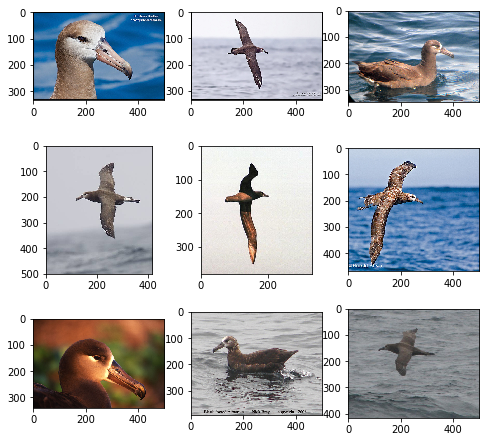

In [7]:
check_images(trainval)

### resized images

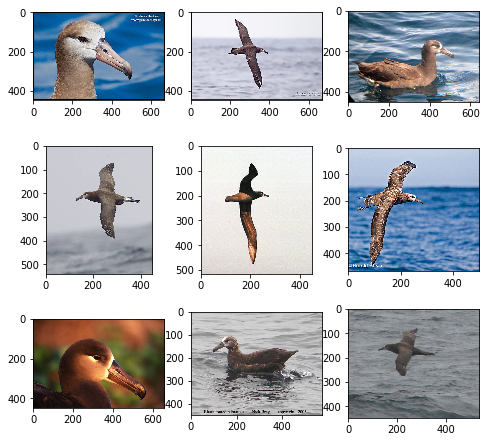

In [8]:
# resize images to generate cropped 448x448 images while keeping aspect ratio
trainval_resized = resize_images(trainval, size_target=(448,448), flg_keep_aspect=True)
check_images(trainval_resized)

### flipped images

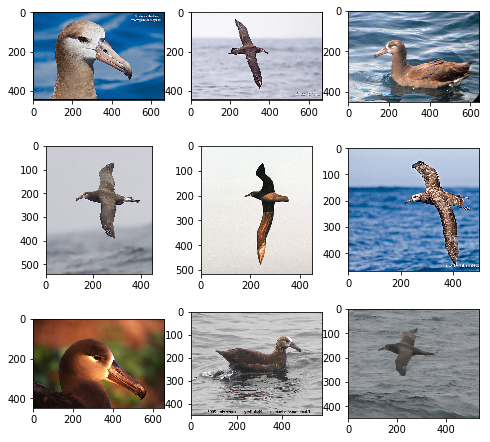

In [9]:
trainval_resized_flipped = trainval_resized.copy()
for i in range(9):
    trainval_resized_flipped[i] = horizontal_flip_image(trainval_resized_flipped[i])
check_images(trainval_resized_flipped)

### center cropped images

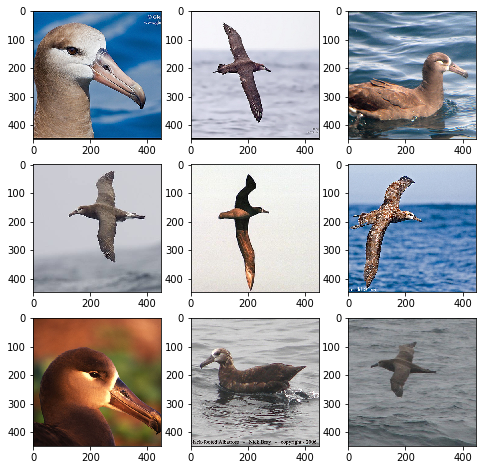

In [10]:
trainval_resized_cropped = trainval_resized.copy()
for i in range(9):
    trainval_resized_cropped[i] = center_crop_image(trainval_resized_cropped[i])
check_images(trainval_resized_cropped)

### random cropped images

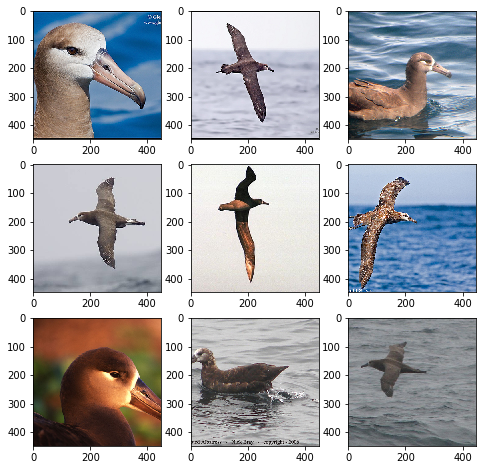

In [11]:
trainval_resized_cropped = trainval_resized.copy()
for i in range(9):
    trainval_resized_cropped[i] = random_crop_image(trainval_resized_cropped[i])
check_images(trainval_resized_cropped)

# load data

### bypass keras preprocessing for resizing images while keeping aspect ratio

In [12]:
import keras.backend as backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

class DirectoryIterator(keras.preprocessing.image.DirectoryIterator):
    def _get_batches_of_transformed_samples(self, index_array):
        
        batch_x = np.zeros(
            (len(index_array),) + self.image_shape,
            dtype=backend.floatx())
        grayscale = self.color_mode == 'grayscale'
        
        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(os.path.join(self.directory, fname),
                           grayscale=grayscale,
                           target_size=None,
                           interpolation=self.interpolation)
            x = img_to_array(img, data_format=self.data_format)
            # Pillow images should be closed after `load_img`,
            # but not PIL images.
            if hasattr(img, 'close'):
                img.close()
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(backend.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros(
                (len(batch_x), self.num_classes),
                dtype=backend.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x
        
        return batch_x, batch_y


class ImageDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=16, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):

        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation)

In [13]:
def load_data(
    path_data_train=None
    ,path_data_valid=None

    ,size_width=448
    ,size_heigth=448
    ,size_mini_batch=16
    
    ,flg_debug=False
    ,**kwargs
):
                    
    # set preprocessing functions       
    func_train = lambda x :normalize_image(
                                random_crop_image(
                                    horizontal_flip_image(
                                        resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True)
                                    )
                                )
                                ,mean=[123.82988033, 127.3509729, 110.25606303]
                            )
    func_valid = lambda x :normalize_image(
                                center_crop_image(
                                    resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True)
                                )
                                ,mean=[123.82988033, 127.3509729, 110.25606303]
                            )
    
    # set image_data_generator 
    gen_train = ImageDataGenerator(   
                    preprocessing_function=func_train
                )

    gen_valid = ImageDataGenerator(
                    preprocessing_function=func_valid
                )

    gen_dir_train = gen_train.flow_from_directory(
                            path_data_train
                            ,target_size=(size_heigth, size_width)
                            ,batch_size=size_mini_batch
                        )

    gen_dir_valid = gen_valid.flow_from_directory(
                            path_data_valid
                            ,target_size=(size_heigth, size_width)
                            ,batch_size=size_mini_batch
                            ,shuffle=False
                    )

    return gen_dir_train, gen_dir_valid

In [14]:
gen_dir_train, gen_dir_valid = load_data(
                                    path_data_train=PATH_DATA_ROOT_CUB200+"/splitted/train"
                                    ,path_data_valid=PATH_DATA_ROOT_CUB200+"/splitted/valid"
                                    ,size_mini_batch=9
                                )

Found 5994 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


### check preprocessed training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


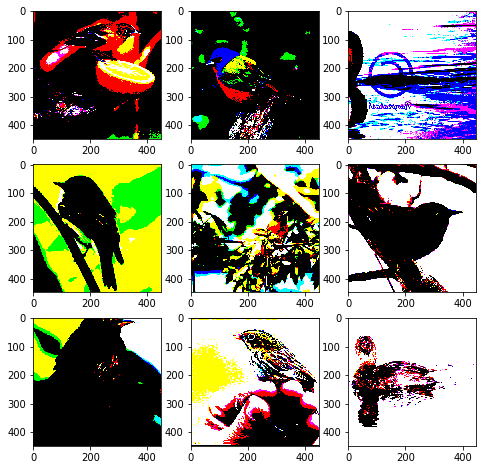

In [15]:
x_train, y_train = gen_dir_train.next()
check_images(x_train)

# build model

In [16]:
from keras.initializers import glorot_normal

def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)


def build_model(
    size_heigth=448
    ,size_width=448
    ,no_class=200
    ,no_last_layer_backbone=17
    
    ,name_optimizer="sgd"
    ,rate_learning=1.0
    ,rate_decay_learning=0.0
    ,rate_decay_weight=0.0
    
    ,name_initializer="glorot_normal"
    ,name_activation_logits="softmax"
    ,name_loss="categorical_crossentropy"

    ,flg_debug=False
    ,**kwargs
):
    
    keras.backend.clear_session()
    
    print("-------------------------------")
    print("parameters:")
    for key, val in locals().items():
        if not val == None and not key == "kwargs":
            print("\t", key, "=",  val)
    print("-------------------------------")
    
    ### 
    ### load pre-trained model
    ###
    tensor_input = keras.layers.Input(shape=[size_heigth,size_width,3])
    model_detector = keras.applications.vgg16.VGG16(
                            input_tensor=tensor_input
                            , include_top=False
                            , weights='imagenet'
                        )
    

    ### 
    ### bi-linear pooling
    ###

    # extract features from detector
    x_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape
    if flg_debug:
        print("shape_detector : {}".format(shape_detector))

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = shape_detector
    x_extractor = x_detector
    if flg_debug:
        print("shape_extractor : {}".format(shape_extractor))
        
    
    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = keras.layers.Reshape(
            [
                shape_detector[1] * shape_detector[2] , shape_detector[-1]
            ]
        )(x_detector)
    if flg_debug:
        print("x_detector shape after rehsape ops : {}".format(x_detector.shape))
        
    x_extractor = keras.layers.Reshape(
            [
                shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]
            ]
        )(x_extractor)
    if flg_debug:
        print("x_extractor shape after rehsape ops : {}".format(x_extractor.shape))
        
        
    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Lambda(outer_product)(
        [x_detector, x_extractor]
    )
    if flg_debug:
        print("x shape after outer products ops : {}".format(x.shape))
        
        
    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    if flg_debug:
        print("x shape after rehsape ops : {}".format(x.shape))
        
        
    # signed square-root 
    x = keras.layers.Lambda(signed_sqrt)(x)
    if flg_debug:
        print("x shape after signed-square-root ops : {}".format(x.shape))
        
    # L2 normalization
    x = keras.layers.Lambda(L2_norm)(x)
    if flg_debug:
        print("x shape after L2-Normalization ops : {}".format(x.shape))



    ### 
    ### attach FC-Layer
    ###

    if name_initializer != None:
            name_initializer = eval(name_initializer+"()")
            
    x = keras.layers.Dense(
            units=no_class
            ,kernel_regularizer=keras.regularizers.l2(rate_decay_weight)
            ,kernel_initializer=name_initializer
        )(x)
    if flg_debug:
        print("x shape after Dense ops : {}".format(x.shape))
    tensor_prediction = keras.layers.Activation(name_activation_logits)(x)
    if flg_debug:
        print("prediction shape : {}".format(tensor_prediction.shape))

        

    ### 
    ### compile model
    ###
    model_bilinear = keras.models.Model(
                        inputs=[tensor_input]
                        , outputs=[tensor_prediction]
                    )
    
    
    # fix pre-trained weights
    for layer in model_detector.layers:
        layer.trainable = False
        
        
    # define optimizers
    opt_adam = keras.optimizers.adam(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_rms = keras.optimizers.RMSprop(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_sgd = keras.optimizers.SGD(
                    lr=rate_learning
                    , decay=rate_decay_learning
                    , momentum=0.9
                    , nesterov=False
                )
    optimizers ={
        "adam":opt_adam
        ,"rmsprop":opt_rms
        ,"sgd":opt_sgd
    }
    
    model_bilinear.compile(
        loss=name_loss
        , optimizer=optimizers[name_optimizer]
        , metrics=["categorical_accuracy"]
    )
    
    
    
    if flg_debug:
        model_bilinear.summary()
    
    return model_bilinear

In [17]:
model = build_model(
            # number of output classes, 200 for CUB200
            no_class = NO_CLASS

            # pretrained model specification, using VGG16
            # "block5_conv3 "
            ,no_last_layer_backbone = 17
    
            # training parametes
            ,rate_learning=1.0
            ,rate_decay_weight=1e-8
    
            ,flg_debug=True
        )

-------------------------------
parameters:
	 flg_debug = True
	 name_loss = categorical_crossentropy
	 name_activation_logits = softmax
	 name_initializer = glorot_normal
	 rate_decay_weight = 1e-08
	 rate_decay_learning = 0.0
	 rate_learning = 1.0
	 name_optimizer = sgd
	 no_last_layer_backbone = 17
	 no_class = 200
	 size_width = 448
	 size_heigth = 448
-------------------------------
shape_detector : (None, 28, 28, 512)
shape_extractor : (None, 28, 28, 512)
x_detector shape after rehsape ops : (?, 784, 512)
x_extractor shape after rehsape ops : (?, 784, 512)
x shape after outer products ops : (?, 512, 512)
x shape after rehsape ops : (?, 262144)
x shape after signed-square-root ops : (?, 262144)
x shape after L2-Normalization ops : (?, 262144)
x shape after Dense ops : (?, 200)
prediction shape : (?, 200)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to   

# train model

In [18]:
def train_model(
        model=None
        ,name_model="BCNN_keras"
        ,gen_dir_train=None
        ,gen_dir_valid=None
        ,max_epoch=50
    ):
    
    path_model = "./model/{}/".format(name_model)
    if not os.path.exists(path_model):
        os.mkdir(path_model)
        
    now = time.strftime("%Y%m%d%H%M%S", time.localtime())
        
    # callback setting
    callback_logger = keras.callbacks.CSVLogger(
                            path_model +  "log_training_{}.csv".format(now)
                            , separator=','
                            , append=False
                        )
    callack_saver = keras.callbacks.ModelCheckpoint(
                        path_model
                            + "E[{epoch:02d}]"
                            + "_LOS[{val_loss:.3f}]"
                            + "_ACC[{val_categorical_accuracy:.3f}]"
                            + ".hdf5" 
                        , monitor='val_loss'
                        , verbose=0
                        , mode='auto'
                        , period=10
                        , save_best_only=True
                    )
    callback_reducer = keras.callbacks.ReduceLROnPlateau(
                                monitor='val_loss'
                                , factor=0.5
                                , patience=5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
                                , min_lr=1e-6
                                , min_delta=1e-3
                            )
    callback_stopper = keras.callbacks.EarlyStopping(
                            monitor='val_loss'
                            , min_delta=1e-3
                            , patience=10
                            , verbose=0
                            , mode='auto'
                        )
    list_callback = [
        callback_logger
        ,callack_saver
        ,callback_reducer
        ,callback_stopper
    ]
            
    hist = model.fit_generator(
                gen_dir_train
                , epochs=max_epoch
                , validation_data=gen_dir_valid
                ,callbacks=list_callback
                ,workers=3
                ,verbose=1
            )
        
    model.save_weights(
        path_model
            + "E[{}]".format(len(hist.history['val_loss']))
            + "_LOS[{:.3f}]".format(hist.history['val_loss'][-1])
            + "_ACC[{:.3f}]".format(hist.history['val_categorical_accuracy'][-1])
            + ".h5" 
    )
    
    return hist                                              

In [19]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=1

        )

Epoch 1/1
666/666 [==============================] - 189s 283ms/step - loss: 4.4810 - categorical_accuracy: 0.1233 - val_loss: 3.4844 - val_categorical_accuracy: 0.2392


<IPython.core.display.Javascript object>

# finetune only FC-layer

In [20]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=99

        )

Epoch 1/99
666/666 [==============================] - 181s 272ms/step - loss: 2.6199 - categorical_accuracy: 0.4631 - val_loss: 2.5336 - val_categorical_accuracy: 0.4253
Epoch 2/99
666/666 [==============================] - 182s 273ms/step - loss: 1.7534 - categorical_accuracy: 0.6578 - val_loss: 2.0012 - val_categorical_accuracy: 0.5635
Epoch 3/99
666/666 [==============================] - 177s 266ms/step - loss: 1.2876 - categorical_accuracy: 0.7719 - val_loss: 1.8264 - val_categorical_accuracy: 0.5796
Epoch 4/99
666/666 [==============================] - 154s 231ms/step - loss: 1.0062 - categorical_accuracy: 0.8282 - val_loss: 1.6020 - val_categorical_accuracy: 0.6313
Epoch 5/99
666/666 [==============================] - 153s 230ms/step - loss: 0.7951 - categorical_accuracy: 0.8804 - val_loss: 1.5302 - val_categorical_accuracy: 0.6388
Epoch 6/99
666/666 [==============================] - 153s 230ms/step - loss: 0.6669 - categorical_accuracy: 0.9117 - val_loss: 1.4283 - val_categoric

Epoch 49/99
666/666 [==============================] - 153s 230ms/step - loss: 0.0510 - categorical_accuracy: 0.9998 - val_loss: 1.0203 - val_categorical_accuracy: 0.7409
Epoch 50/99
666/666 [==============================] - 153s 230ms/step - loss: 0.0503 - categorical_accuracy: 0.9997 - val_loss: 1.0214 - val_categorical_accuracy: 0.7371
Epoch 51/99
666/666 [==============================] - 153s 230ms/step - loss: 0.0498 - categorical_accuracy: 1.0000 - val_loss: 1.0220 - val_categorical_accuracy: 0.7368
Epoch 52/99
666/666 [==============================] - 154s 230ms/step - loss: 0.0481 - categorical_accuracy: 0.9998 - val_loss: 1.0168 - val_categorical_accuracy: 0.7427
Epoch 53/99
666/666 [==============================] - 154s 231ms/step - loss: 0.0470 - categorical_accuracy: 1.0000 - val_loss: 1.0150 - val_categorical_accuracy: 0.7411
Epoch 54/99
666/666 [==============================] - 154s 230ms/step - loss: 0.0465 - categorical_accuracy: 0.9998 - val_loss: 1.0155 - val_cat

Epoch 97/99
666/666 [==============================] - 154s 231ms/step - loss: 0.0312 - categorical_accuracy: 1.0000 - val_loss: 0.9922 - val_categorical_accuracy: 0.7430
Epoch 98/99
666/666 [==============================] - 154s 231ms/step - loss: 0.0311 - categorical_accuracy: 1.0000 - val_loss: 0.9918 - val_categorical_accuracy: 0.7440


<IPython.core.display.Javascript object>

# finetune ALL-layer

In [21]:
# now all layers are trainable
for layer in model.layers:
    layer.trainable = True

# change LR
opt_sgd = keras.optimizers.SGD(
                lr=1e-3
                , decay=1e-9
                , momentum=0.9
                , nesterov=False
            )
model.compile(
    loss="categorical_crossentropy"
    , optimizer=opt_sgd
    , metrics=["categorical_accuracy"]
)

In [22]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=1

        )

Epoch 1/1
666/666 [==============================] - 287s 431ms/step - loss: 0.7537 - categorical_accuracy: 0.8038 - val_loss: 1.2388 - val_categorical_accuracy: 0.6653


<IPython.core.display.Javascript object>

In [23]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=33

        )

Epoch 1/33
666/666 [==============================] - 284s 426ms/step - loss: 0.2182 - categorical_accuracy: 0.9603 - val_loss: 1.0335 - val_categorical_accuracy: 0.7221
Epoch 2/33
666/666 [==============================] - 284s 427ms/step - loss: 0.0793 - categorical_accuracy: 0.9907 - val_loss: 0.8409 - val_categorical_accuracy: 0.7722
Epoch 3/33
666/666 [==============================] - 284s 427ms/step - loss: 0.0302 - categorical_accuracy: 0.9988 - val_loss: 0.8908 - val_categorical_accuracy: 0.7663
Epoch 4/33
666/666 [==============================] - 285s 427ms/step - loss: 0.0272 - categorical_accuracy: 0.9985 - val_loss: 0.8042 - val_categorical_accuracy: 0.7879
Epoch 5/33
666/666 [==============================] - 285s 427ms/step - loss: 0.0175 - categorical_accuracy: 0.9997 - val_loss: 0.7817 - val_categorical_accuracy: 0.7950
Epoch 6/33
666/666 [==============================] - 284s 427ms/step - loss: 0.0132 - categorical_accuracy: 1.0000 - val_loss: 0.7580 - val_categoric

<IPython.core.display.Javascript object>